# Task 3

### Problem description

The dataset contains various features related to housing prices in California and the goal is to build predictive models using neural networks + PyTorch, then compare your results with the ones presented on the reference web-page.

To make it possible, we have firstly to:

1. **Manipulate the data**
   - This involves preprocessing tasks such as cleaning, normalizing, and splitting the dataset into training and test sets.

2. **Train the model**
   - This step encompasses defining the model architecture, selecting an optimizer and loss function, and feeding the preprocessed data through the model for training.

3. **Compare the model with what's present on the website**
   - After training, evaluate the model's performance using metrics such as accuracy or mean squared error, and compare these results with benchmarks or results mentioned on reference websites.

4. **Describe the status quo in the literature**
   - Review current research papers, articles, and benchmarks related to your model or problem statement to understand the current advancements and where your work stands in relation to the broader scientific community.


### import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from math import ceil
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
from scipy.stats import normaltest
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, LinearRegression
import statsmodels.api as sm
from sklearn.manifold import TSNE
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

### Manipulate the data

The first step is to load the data and check for missing values. This is important because missing values can cause issues during training and evaluation. If missing values are present, we need to decide how to handle them. Common strategies include removing rows with missing values, imputing missing values with the mean or median, or using more advanced imputation techniques such as k-nearest neighbors or regression imputation.

In [2]:
full_df = pd.read_csv('housing.csv')
print(full_df.shape)
full_df.head()

(20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
is_nan_in_columns = full_df.isna().any()

# Print columns with NaN values
print("Columns with NaN values:")
print(is_nan_in_columns)

Columns with NaN values:
longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool


In [4]:
full_df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
full_df[pd.isnull(full_df).any(axis=1)].head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY
738,-122.14,37.67,37.0,3342.0,NaN,1635.0,557.0,4.7933,186900.0,NEAR BAY
1097,-121.77,39.66,20.0,3759.0,NaN,1705.0,600.0,4.7120,158600.0,INLAND
1350,-121.95,38.03,5.0,5526.0,NaN,3207.0,1012.0,4.0767,143100.0,INLAND
1456,-121.98,37.96,22.0,2987.0,NaN,1420.0,540.0,3.6500,204100.0,INLAND
1493,-122.01,37.94,23.0,3741.0,NaN,1339.0,499.0,6.7061,322300.0,NEAR BAY


We can observe there are NaN values in the case of total bedrooms

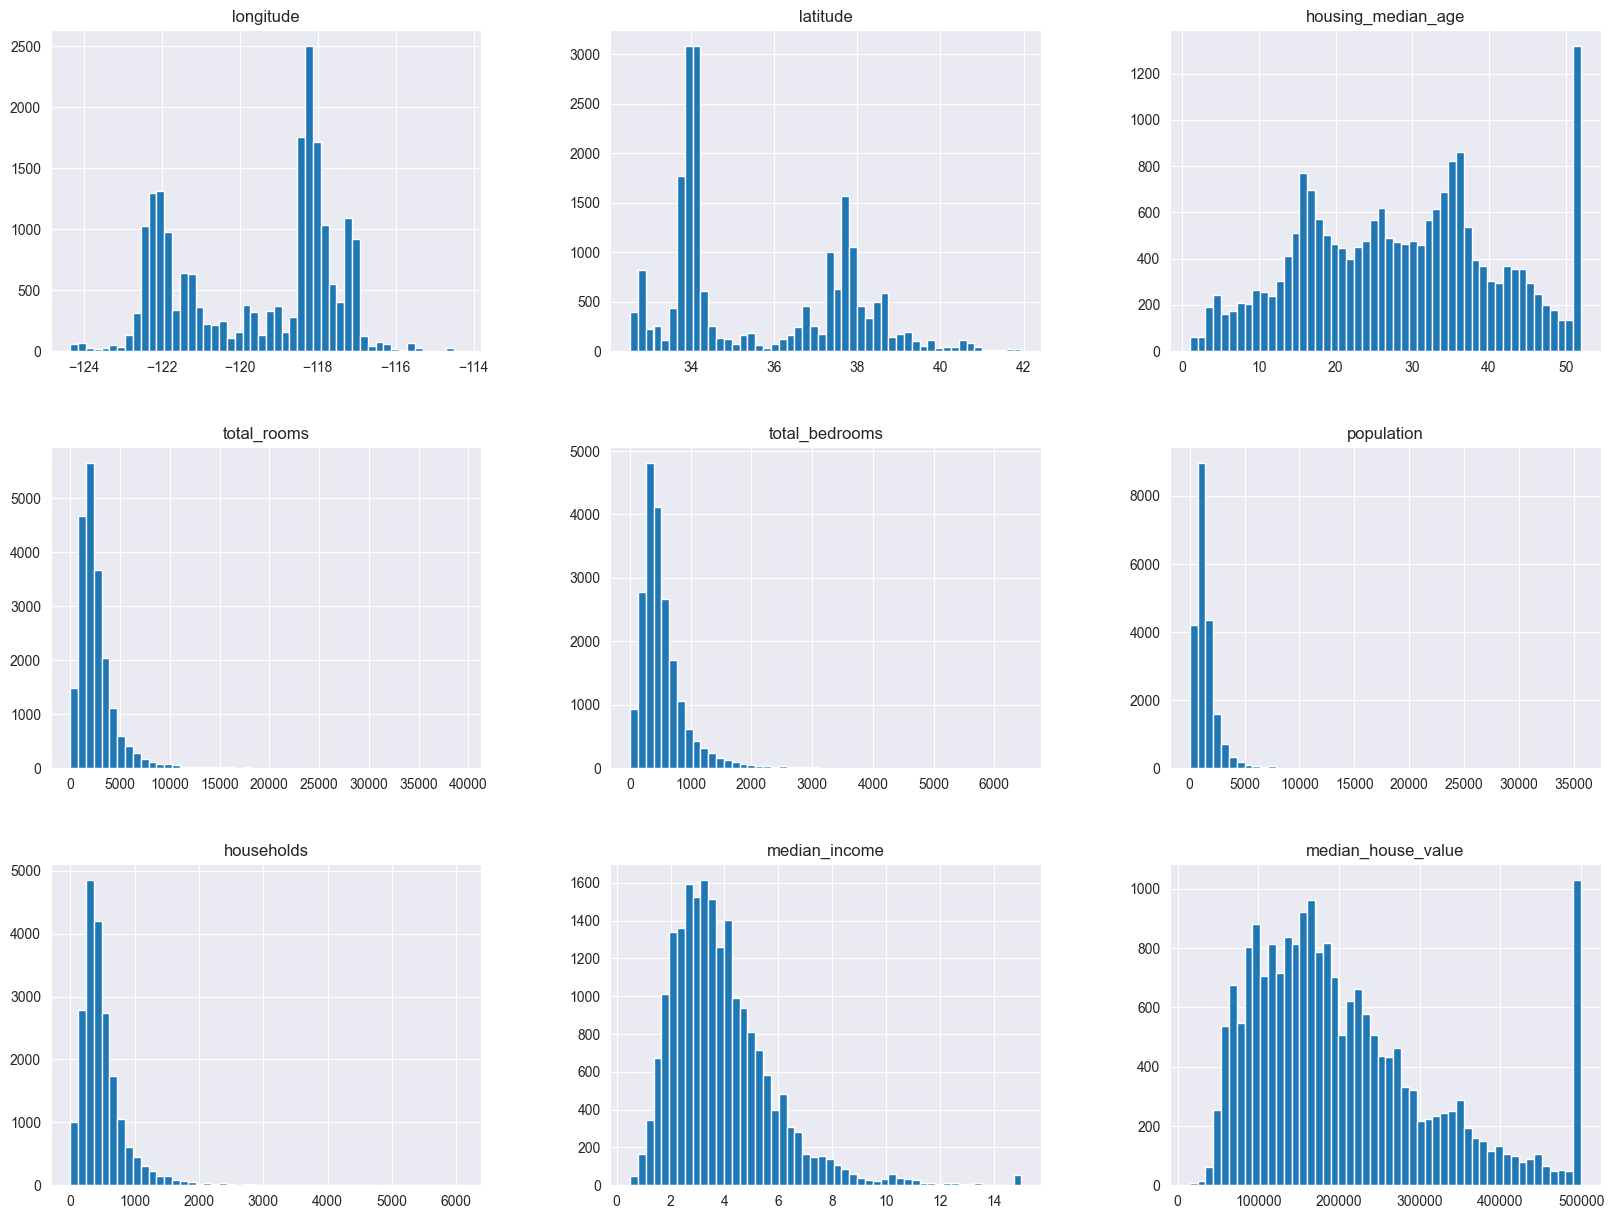

In [6]:
full_df.hist(bins=50,figsize=(20,15))
plt.show()

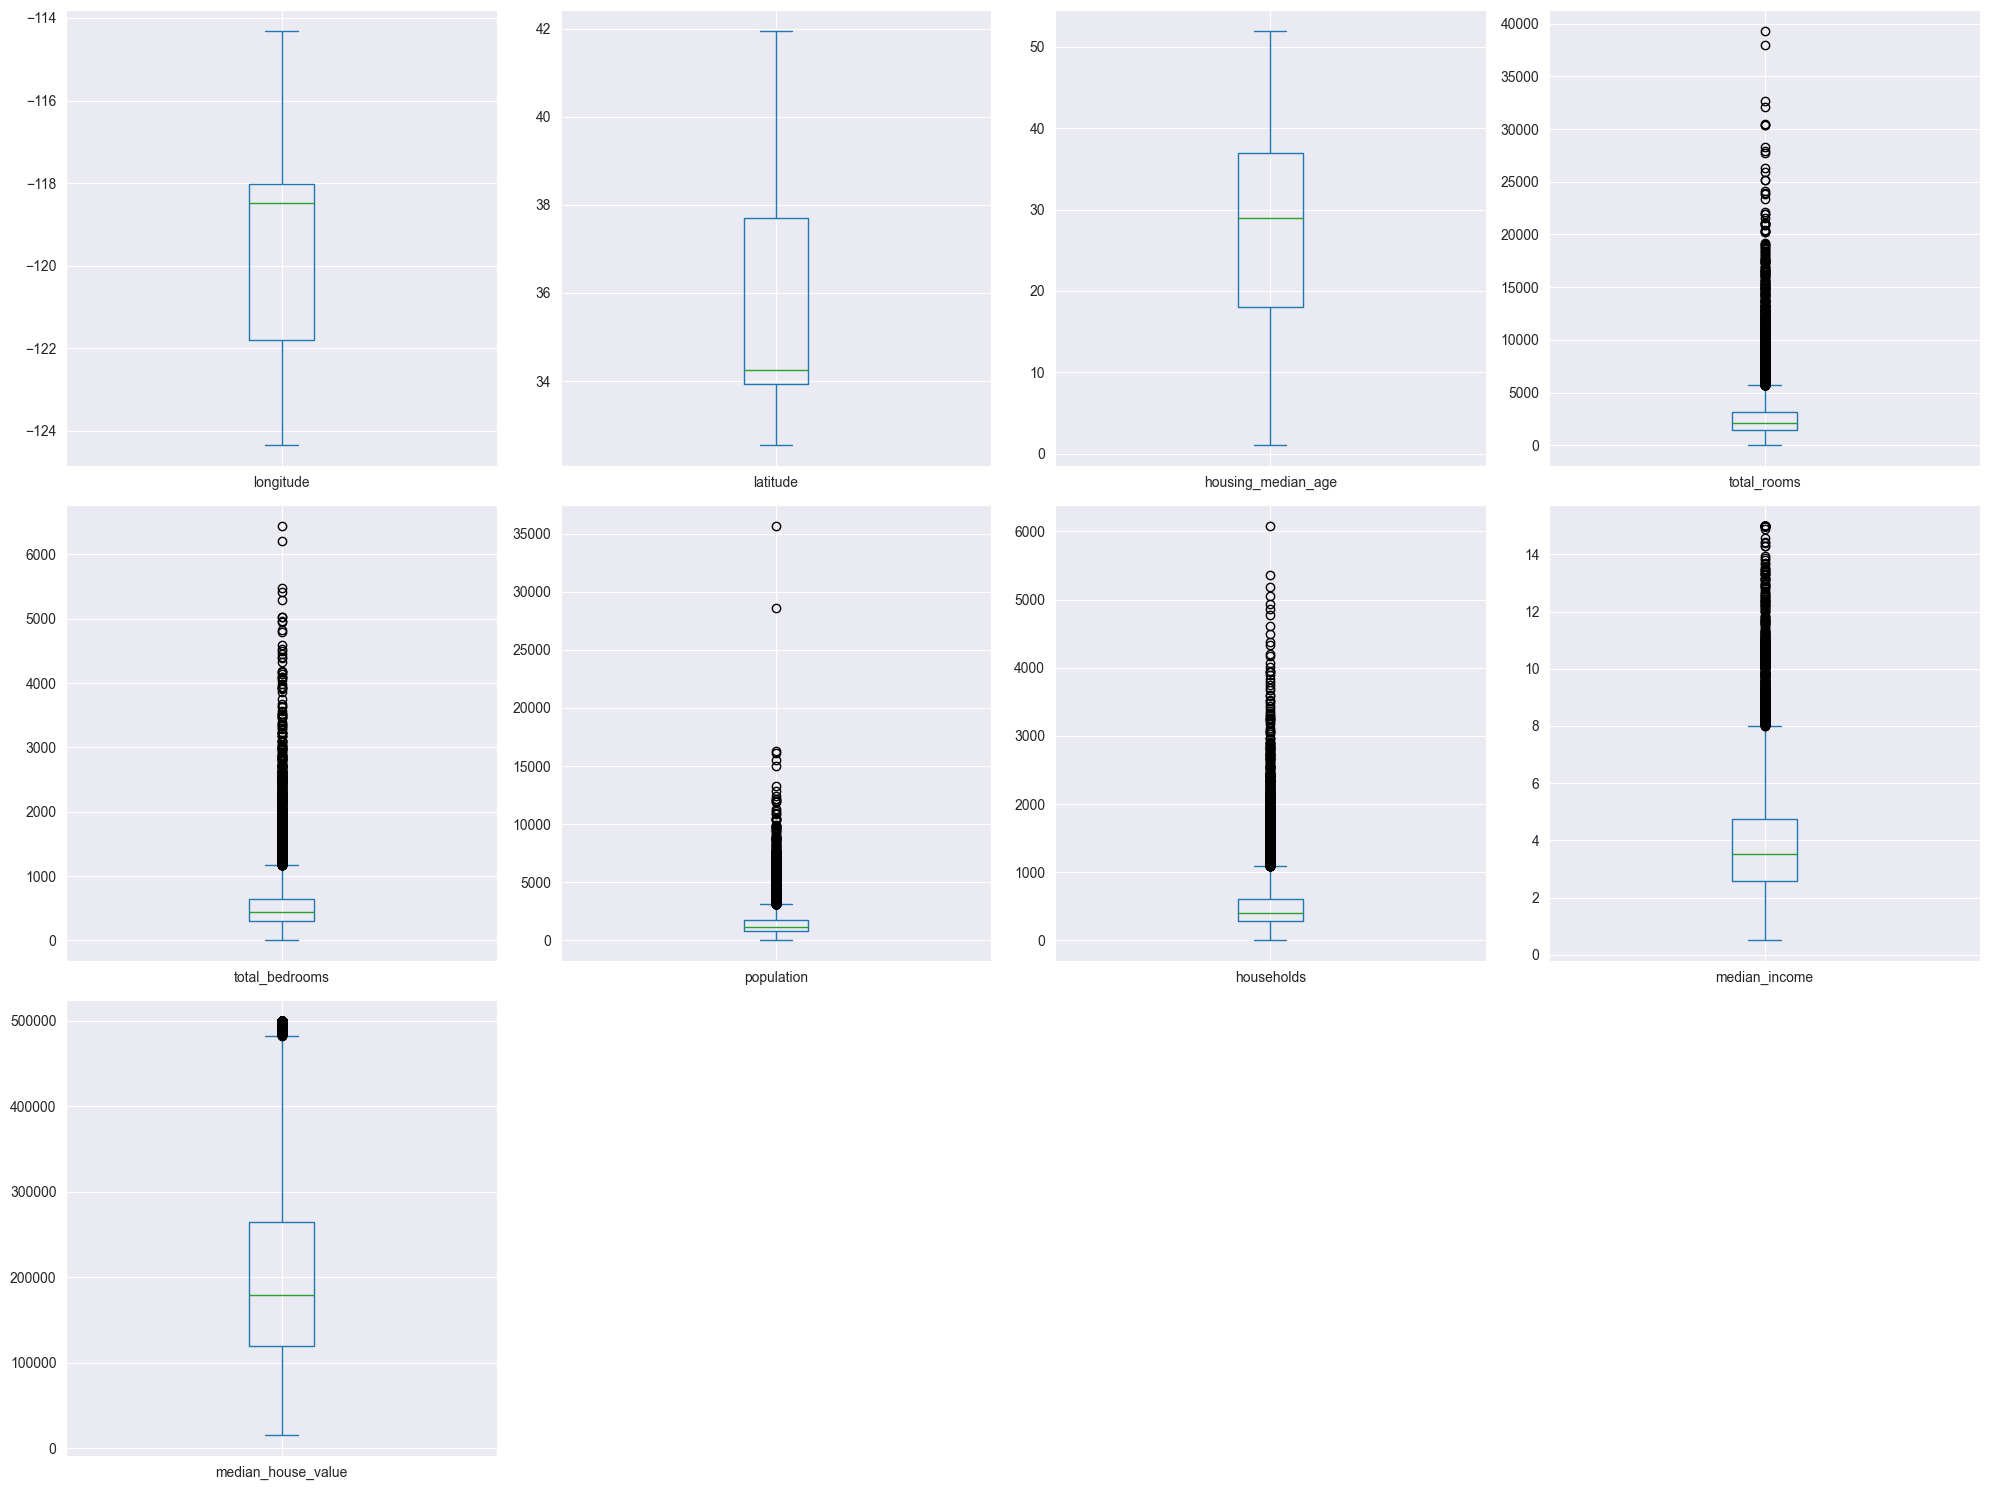

In [7]:
# Box plots
full_df.plot(kind='box', subplots=True, layout=(ceil(len(full_df.columns) / 4), 4), figsize=(20, 15))
plt.tight_layout()
plt.show()

What we can notice in this case is that data tends to be skewed, however, it has several outliers givne the difference of the market. So it's important to avoid an overfitting of the model

<Axes: xlabel='longitude', ylabel='latitude'>

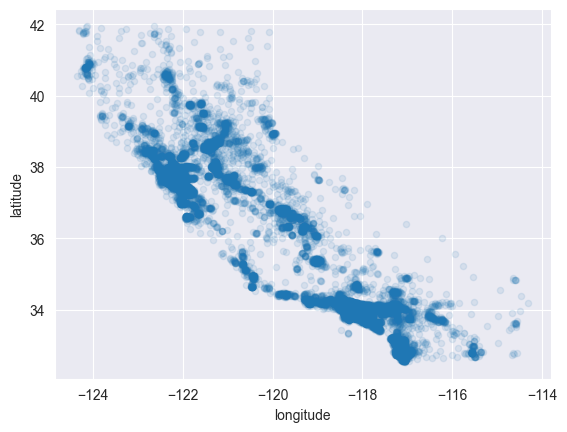

In [8]:
full_df.plot(kind="scatter",x="longitude",y="latitude", alpha=0.1)

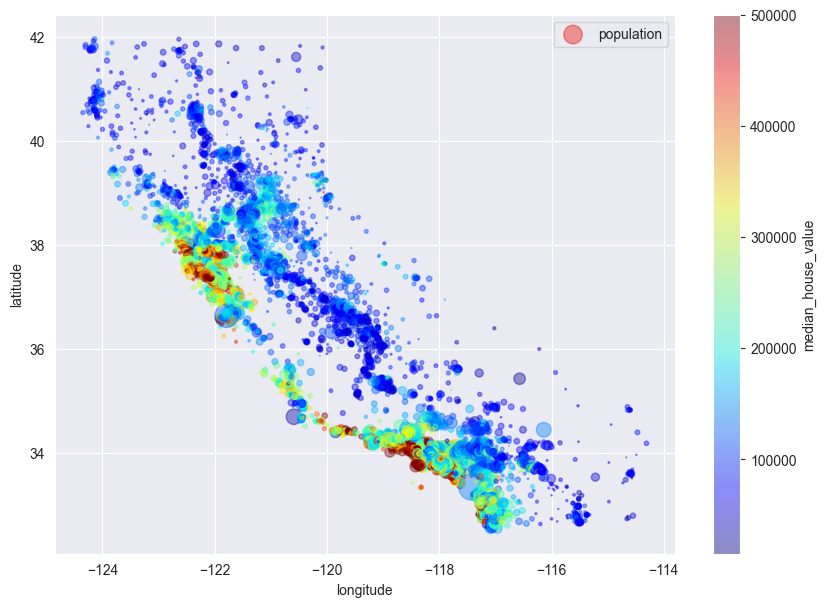

In [9]:
full_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=full_df["population"]/100, label="population", figsize=(10,7),
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

When can learn from this exercise that only training the model would make us go nowhere, because the loss would be too high. Indeed, before doing that, it's categorical to treat the data in an adequate way

In [10]:
max_target=full_df['median_house_value'].max()
print("The largest median value:",max_target)
print("The # of values, equal to the largest:", sum(full_df['median_house_value']==max_target))
print("The % of values, equal to the largest:", sum(full_df['median_house_value']==max_target)/full_df.shape[0])

The largest median value: 500001.0
The # of values, equal to the largest: 965
The % of values, equal to the largest: 0.04675387596899225


In [11]:
min_target=full_df['median_house_value'].min()
print("The smallest median value:",min_target)
print("The # of values, equal to the smallest:", sum(full_df['median_house_value']==min_target))
print("The % of values, equal to the smallest:", sum(full_df['median_house_value']==min_target)/full_df.shape[0])

The smallest median value: 14999.0
The # of values, equal to the smallest: 4
The % of values, equal to the smallest: 0.0001937984496124031


When data is clipped, one way to reconstruct it is to assume data follows a normal distribution. Given this example, it's possible to notice that the data doesn't follow a normal distribution and, for this reason, there is no way to reconstruct it without having a prior knowledge of a particular distribution. We tend to assume a normal distribution as it has the highest entropy (lowest assumptions of the model). To demonstrate so the authors used

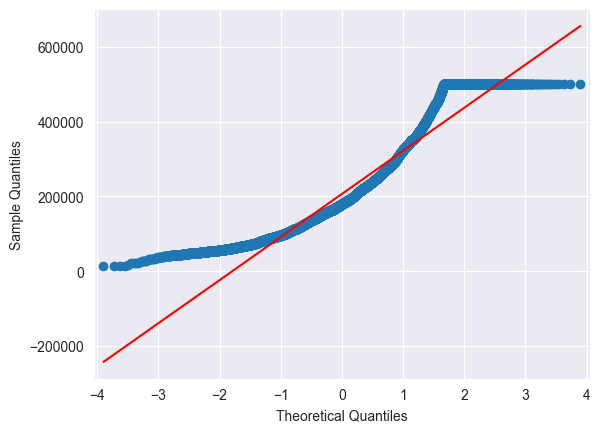

In [12]:
qqplot(full_df['median_house_value'], line='s')
pyplot.show()

In [13]:
stat, p = normaltest(full_df['median_house_value'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

Statistics=2430.931, p=0.000
The null hypothesis can be rejected


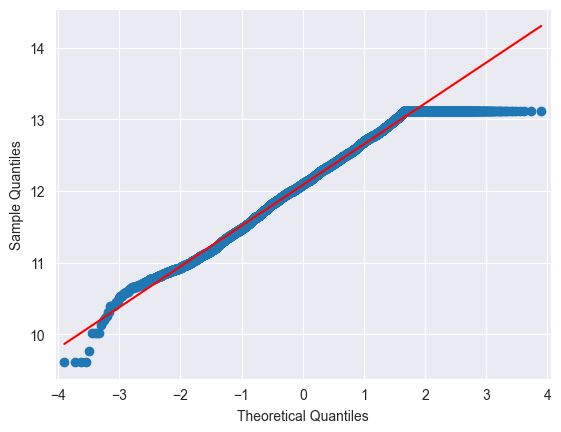

In [14]:
target_log=np.log1p(full_df['median_house_value'])
qqplot(target_log, line='s')
pyplot.show()

In [15]:
stat, p = normaltest(target_log)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

Statistics=359.555, p=0.000
The null hypothesis can be rejected


In [16]:
max_house_age=full_df['housing_median_age'].max()
print("The largest value:",max_house_age)
print("The # of values, equal to the largest:", sum(full_df['housing_median_age']==max_house_age))
print("The % of values, equal to the largest:", sum(full_df['housing_median_age']==max_house_age)/full_df.shape[0])


The largest value: 52.0
The # of values, equal to the largest: 1273
The % of values, equal to the largest: 0.06167635658914729


In [17]:
max_house_age

52.0

In [18]:
full_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [19]:
full_df['age_clipped']=full_df['housing_median_age']==max_house_age

/var/folders/v1/vssy438928nbwjshp4t6ky040000gn/T/ipykernel_18215/188013549.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_y = pd.DataFrame(full_df).corr()


<Axes: >

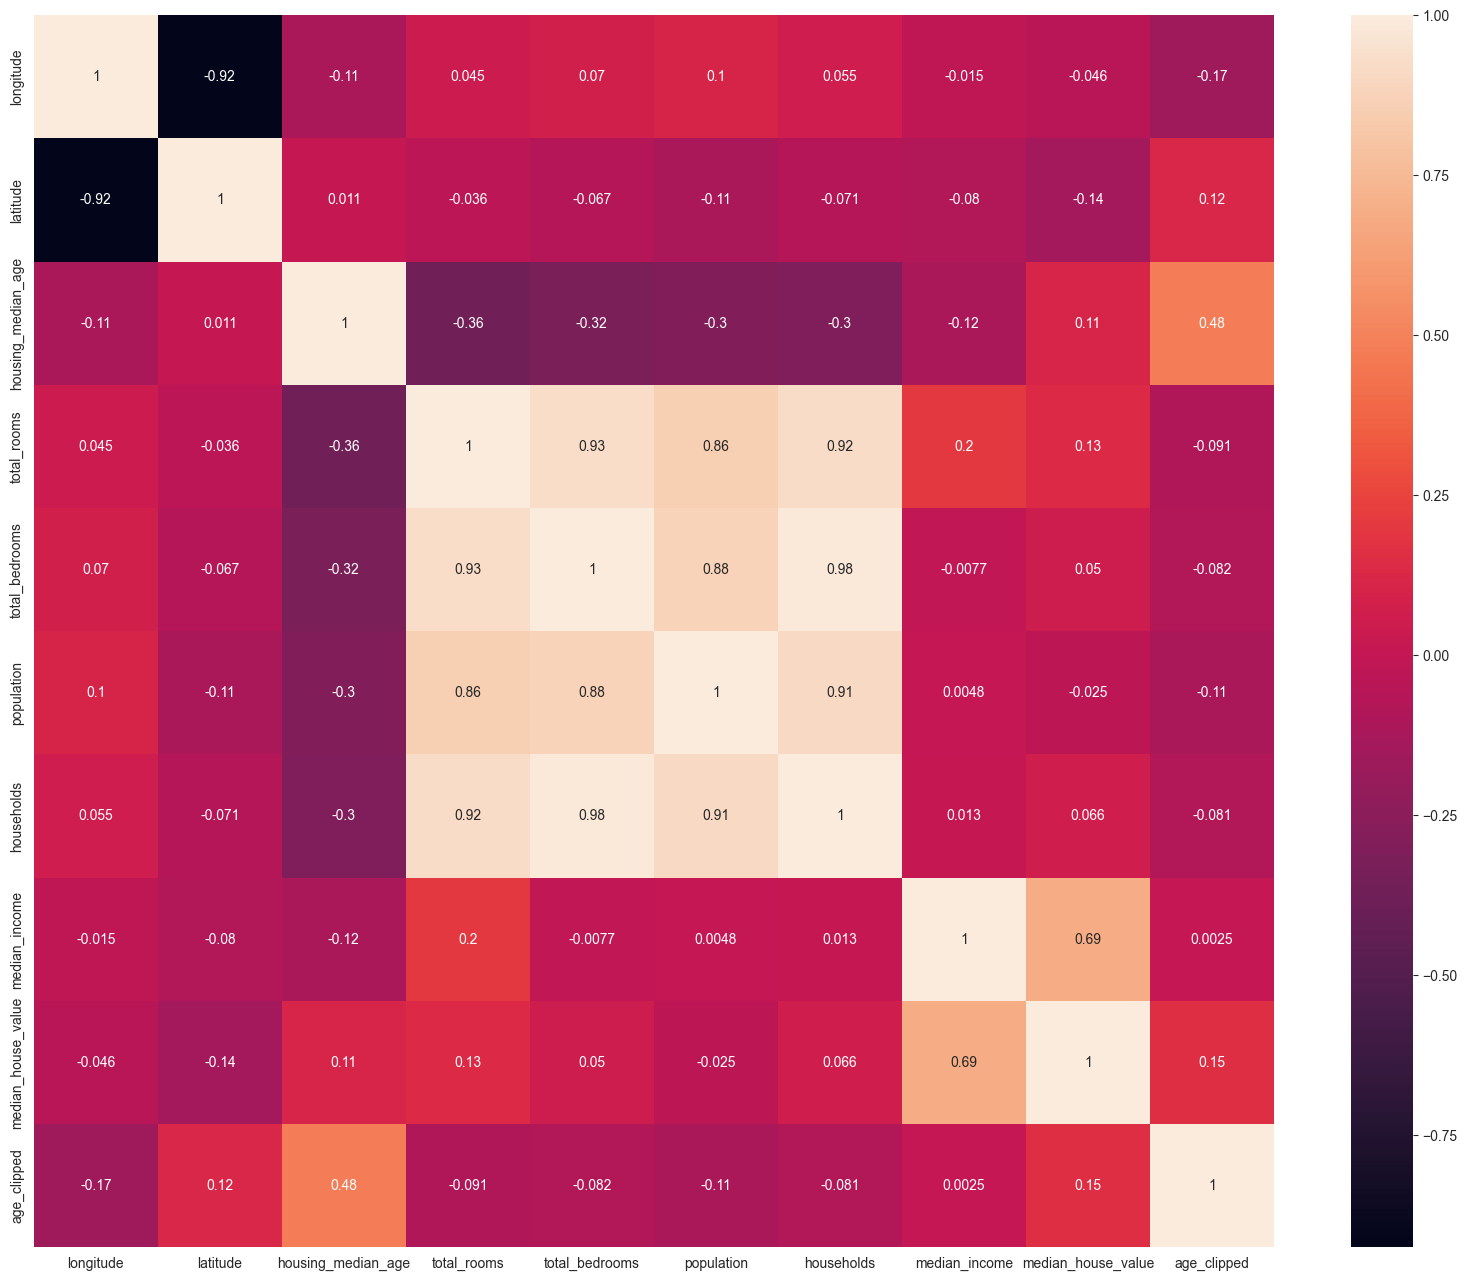

In [20]:
corr_y = pd.DataFrame(full_df).corr()
plt.rcParams['figure.figsize'] = (20, 16)  # Increase the size of the heatmap
sns.heatmap(corr_y,
            xticklabels=corr_y.columns.values,
            yticklabels=corr_y.columns.values, annot=True)


We can also add log values to the dataset

In [21]:
full_df['median_house_value_log']=np.log1p(full_df['median_house_value'])
full_df['median_house_value_log']=np.log1p(full_df['median_house_value'])

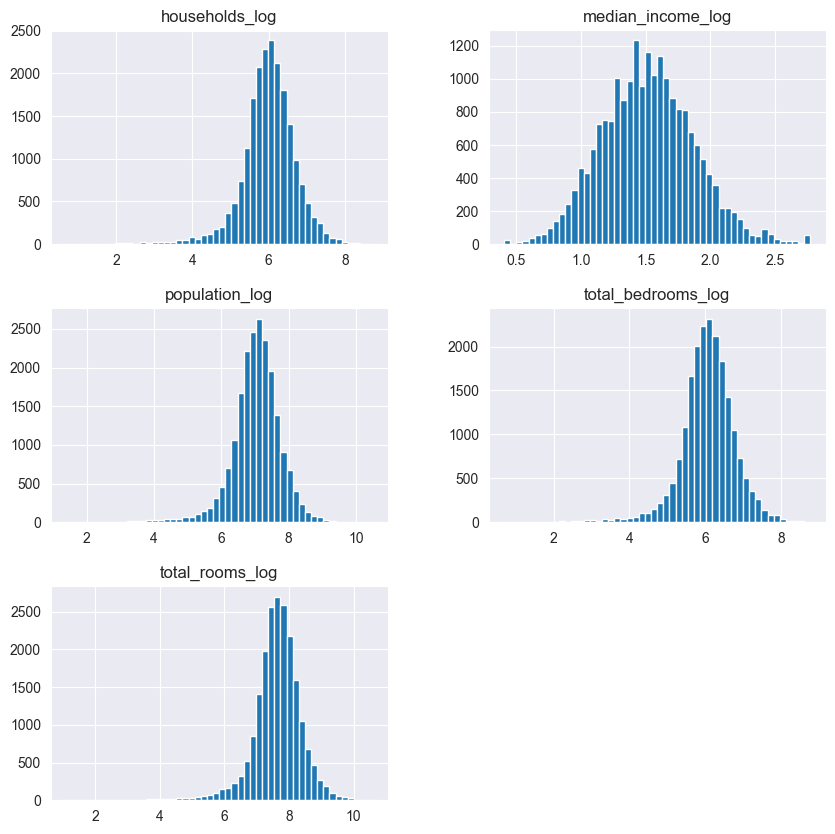

In [22]:
skewed_features=['households','median_income','population', 'total_bedrooms', 'total_rooms']
log_numerical_features=[]
for f in skewed_features:
    full_df[f + '_log']=np.log1p(full_df[f])
    log_numerical_features.append(f + '_log')

full_df[log_numerical_features].hist(bins=50, figsize=(10, 10))

full_df['median_house_value_log']=np.log1p(full_df['median_house_value'])

As stated in the tutorial, it's possible to notice:

- **House values are significantly correlated with median income.** This suggests that median income is a strong predictor of house value and should be considered carefully in any predictive models.

- **Number of households is not 100% correlated with population.** This observation opens up the possibility of adding `average_size_of_household` as a feature to potentially improve model performance by capturing information not directly evident from just population or the number of households.

- **Longitude and Latitude should be analyzed separately.** While just correlating these with the target variable might not be very revealing, spatial analysis or considering them in the context of geographical features could yield useful insights.

- **There is a set of highly correlated features:** number of rooms, bedrooms, population, and households. For models that assume feature independence (like linear models), or to simplify the model, reducing the dimensionality of this subset could be beneficial. Techniques like PCA (Principal Component Analysis) could be used for this purpose.

- **Total_bedrooms is one of these highly correlated features.** Given its high correlation with other features, missing values for `total_bedrooms` can potentially be filled with high precision using a simple linear regression model against one or more of the correlated features.


In [23]:
from sklearn.metrics import mean_squared_error
lin = LinearRegression()

# we will train our model based on all numerical non-target features with not NaN total_bedrooms
appropriate_columns = full_df.drop(['median_house_value','median_house_value_log',
                            'ocean_proximity', 'total_bedrooms_log'],axis=1)
train_data=appropriate_columns[~pd.isnull(full_df).any(axis=1)]

# model will be validated on 25% of train dataset
# theoretically we can use even our test_df dataset (as we don't use target) for this task, but we will not
temp_train, temp_valid = train_test_split(train_data,shuffle = True, test_size = 0.25, random_state=17)

lin.fit(temp_train.drop(['total_bedrooms'],axis=1), temp_train['total_bedrooms'])
np.sqrt(mean_squared_error(lin.predict(temp_valid.drop(['total_bedrooms'],axis=1)),
                           temp_valid['total_bedrooms']))

68.8557759049494

In [24]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   longitude               20640 non-null  float64
 1   latitude                20640 non-null  float64
 2   housing_median_age      20640 non-null  float64
 3   total_rooms             20640 non-null  float64
 4   total_bedrooms          20433 non-null  float64
 5   population              20640 non-null  float64
 6   households              20640 non-null  float64
 7   median_income           20640 non-null  float64
 8   median_house_value      20640 non-null  float64
 9   ocean_proximity         20640 non-null  object 
 10  age_clipped             20640 non-null  bool   
 11  median_house_value_log  20640 non-null  float64
 12  households_log          20640 non-null  float64
 13  median_income_log       20640 non-null  float64
 14  population_log          20640 non-null

In [25]:
lin.fit(train_data.drop(['total_bedrooms'],axis=1), train_data['total_bedrooms'])

full_df['total_bedrooms_is_nan']=pd.isnull(full_df).any(axis=1).astype(int)

full_df['total_bedrooms'].loc[pd.isnull(full_df).any(axis=1)]=\
lin.predict(full_df.drop(['median_house_value','median_house_value_log','total_bedrooms','total_bedrooms_log',
               'ocean_proximity','total_bedrooms_is_nan'],axis=1)[pd.isnull(full_df).any(axis=1)])

#linear regression can lead to negative predictions, let's change it
full_df['total_bedrooms']=full_df['total_bedrooms'].apply(lambda x: max(x,0))

/var/folders/v1/vssy438928nbwjshp4t6ky040000gn/T/ipykernel_18215/2492322326.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['total_bedrooms'].loc[pd.isnull(full_df).any(axis=1)]=\


In [26]:
full_df['total_bedrooms_log']=np.log1p(full_df['total_bedrooms'])
print(full_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   longitude               20640 non-null  float64
 1   latitude                20640 non-null  float64
 2   housing_median_age      20640 non-null  float64
 3   total_rooms             20640 non-null  float64
 4   total_bedrooms          20640 non-null  float64
 5   population              20640 non-null  float64
 6   households              20640 non-null  float64
 7   median_income           20640 non-null  float64
 8   median_house_value      20640 non-null  float64
 9   ocean_proximity         20640 non-null  object 
 10  age_clipped             20640 non-null  bool   
 11  median_house_value_log  20640 non-null  float64
 12  households_log          20640 non-null  float64
 13  median_income_log       20640 non-null  float64
 14  population_log          20640 non-null

In [57]:
# otherwise we can also do in this way
#deleate all the datapoints where nan appears
full_df = full_df.dropna()

In [27]:
# Split the dataset into features and target variable
X = full_df.drop(['median_house_value', 'ocean_proximity'], axis=1)
y = full_df['median_house_value']

In [28]:
# Assuming X_train is a pandas DataFrame before scaling
numerical_features = list(X.columns)
print(numerical_features)


['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'age_clipped', 'households_log', 'median_income_log', 'population_log', 'total_bedrooms_log', 'total_rooms_log', 'total_bedrooms_is_nan']


In this case, we aren't considering ocean_proximity as it's not a numerical measure. However, this may be a big mistake as it can be a proxy for the house value. For this reason, it can be possible to use one hot encoding

<Axes: title={'center': 'House Value depending on Ocean Proximity'}, xlabel='ocean_proximity', ylabel='median_house_value'>

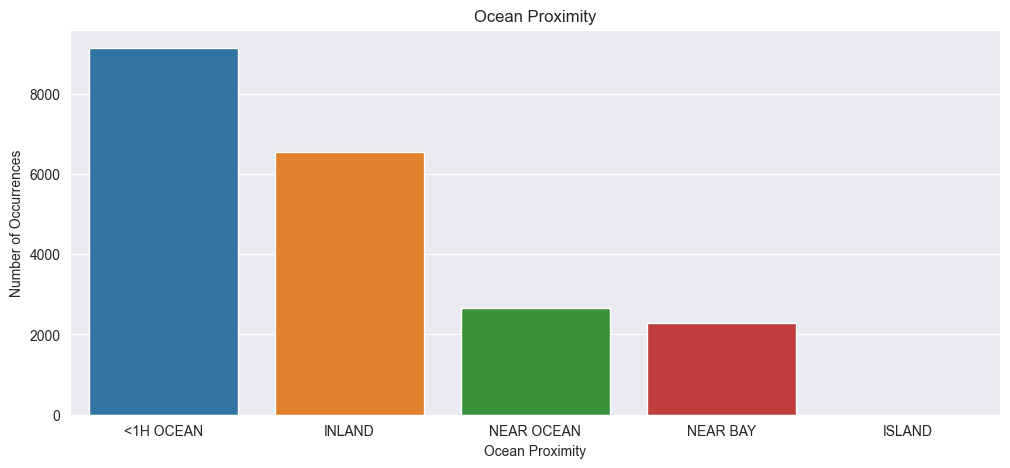

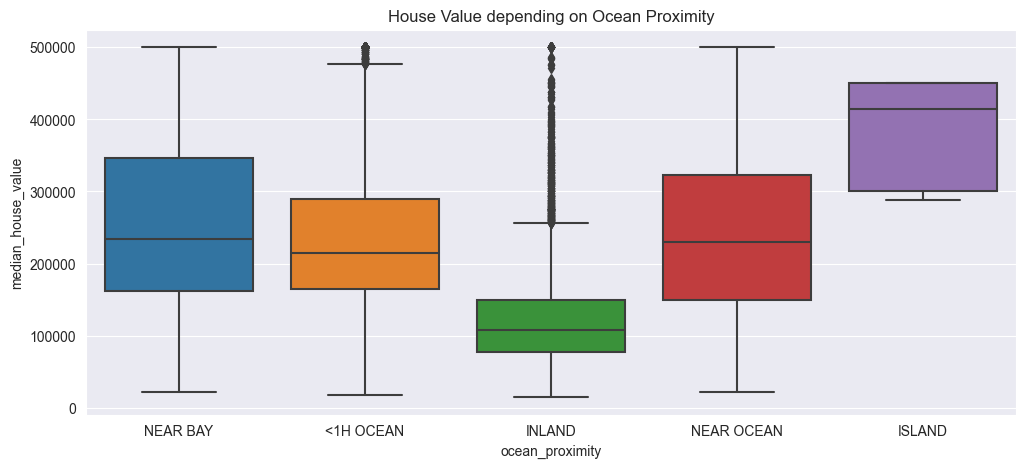

In [29]:
value_count = full_df['ocean_proximity'].value_counts()

plt.figure(figsize=(12, 5))
# Use keyword arguments for x and y
sns.barplot(x=value_count.index, y=value_count.values)
plt.title('Ocean Proximity')
plt.ylabel('Number of Occurrences')
plt.xlabel('Ocean Proximity')

plt.figure(figsize=(12, 5))
plt.title('House Value depending on Ocean Proximity')
sns.boxplot(x="ocean_proximity", y="median_house_value", data=full_df)

In [30]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=full_df['median_house_value_log'],  # Response variable
                                  groups=full_df['ocean_proximity'],  # Grouping variable
                                  alpha=0.025)  # Significance level

# Print the results
print(tukey_results.summary())

# We can see the signifcance of the differences in the groups

    Multiple Comparison of Means - Tukey HSD, FWER=0.03    
  group1    group2   meandiff p-adj   lower   upper  reject
-----------------------------------------------------------
<1H OCEAN     INLAND  -0.6857    0.0 -0.7082 -0.6632   True
<1H OCEAN     ISLAND   0.5333 0.0808 -0.0884   1.155  False
<1H OCEAN   NEAR BAY   0.0484 0.0001   0.016  0.0809   True
<1H OCEAN NEAR OCEAN   0.0025 0.9992 -0.0281  0.0332  False
   INLAND     ISLAND    1.219    0.0  0.5972  1.8407   True
   INLAND   NEAR BAY   0.7341    0.0  0.7004  0.7679   True
   INLAND NEAR OCEAN   0.6883    0.0  0.6563  0.7202   True
   ISLAND   NEAR BAY  -0.4848 0.1407  -1.107  0.1374  False
   ISLAND NEAR OCEAN  -0.5307 0.0837 -1.1528  0.0914  False
 NEAR BAY NEAR OCEAN  -0.0459 0.0053 -0.0855 -0.0063   True
-----------------------------------------------------------


It's interesting to notice how there may be a link between the rarity of the house and its price. For example islands tends to be quite rare but they are also highly expensive. However, inland doesn't follow this trend and tends to be really low in value

In [31]:
# Create one-hot encoded variables for the 'ocean_proximity' feature
ocean_proximity_dummies = pd.get_dummies(full_df['ocean_proximity'], prefix='ocean_proximity')

# Concatenate the one-hot encoded variables back with the original DataFrame minus the 'ocean_proximity' column
full_df_encoded = pd.concat([full_df.drop(['ocean_proximity'], axis=1), ocean_proximity_dummies], axis=1)


In [32]:
full_df_encoded

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,age_clipped,...,median_income_log,population_log,total_bedrooms_log,total_rooms_log,total_bedrooms_is_nan,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,False,...,2.232720,5.777652,4.867534,6.781058,0,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,False,...,2.230165,7.784057,7.009409,8.867850,0,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,True,...,2.111110,6.208590,5.252273,7.291656,0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,True,...,1.893579,6.326149,5.463832,7.150701,0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,True,...,1.578195,6.338594,5.638355,7.395108,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,False,...,0.940124,6.740519,5.926926,7.418181,0,0,1,0,0,0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,False,...,1.268861,5.877736,5.017280,6.548219,0,0,1,0,0,0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,False,...,0.993252,6.915723,6.186209,7.720905,0,0,1,0,0,0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,False,...,1.053336,6.609349,6.016157,7.528869,0,0,1,0,0,0


In [35]:
# Split the dataset into features and target variable
X = full_df_encoded.drop(['median_house_value'], axis=1)
y = full_df_encoded['median_house_value']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.to_numpy()).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.to_numpy()).reshape(-1, 1)

When considering a dataset, it may be helpful to identify the best approach to make the code be properly generalised. In this case, using tsne and umap can be insightful approaches. For this reason,

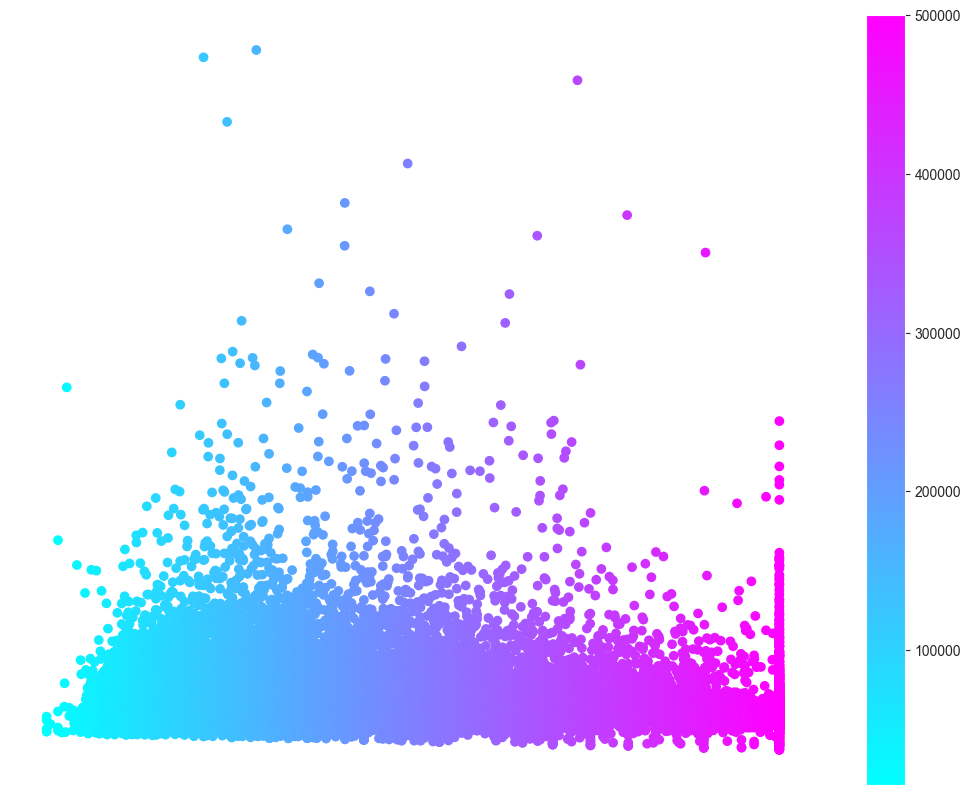

In [34]:
# Initialize PCA with 2 components (for 2D visualization)
pca = PCA(n_components=2)

# Fit and transform the data
X_pca = pca.fit_transform(full_df_encoded)

# Plot the PCA embeddings with coloring based on 'y'
plt.figure(figsize=(13, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="cool")  # Replace 'y' with your variable for coloring
plt.axis('off')  # Hides the axis
plt.colorbar()  # Adds a color bar to the side to interpret the colors
plt.show()

the final output didn't produce the deisred results, fully. So we can repeat the analysis with some changes

In [36]:
# Split the dataset into features and target variable
X = full_df_encoded.drop(['median_house_value'], axis=1)
y = full_df_encoded['median_house_value']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.to_numpy()).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.to_numpy()).reshape(-1, 1)

Epoch: 0, Loss: 237270.6875
Epoch: 100, Loss: 235766.671875
Epoch: 200, Loss: 195727.796875
Epoch: 300, Loss: 108479.03125
Epoch: 400, Loss: 84250.3203125
Epoch: 500, Loss: 75512.609375
Epoch: 600, Loss: 71200.03125
Epoch: 700, Loss: 68472.828125
Epoch: 800, Loss: 66610.4765625
Epoch: 900, Loss: 65234.93359375
Epoch: 1000, Loss: 64147.2109375
Epoch: 1100, Loss: 63279.0625
Epoch: 1200, Loss: 62558.5
Epoch: 1300, Loss: 61945.765625
Epoch: 1400, Loss: 61421.79296875
Epoch: 1500, Loss: 60965.3984375
Epoch: 1600, Loss: 60561.73828125
Epoch: 1700, Loss: 60197.30859375
Epoch: 1800, Loss: 59857.09375
Epoch: 1900, Loss: 59530.80859375
Epoch: 2000, Loss: 59216.55078125
Epoch: 2100, Loss: 58914.51171875
Epoch: 2200, Loss: 58623.76953125
Epoch: 2300, Loss: 58340.56640625
Epoch: 2400, Loss: 58063.671875
Epoch: 2500, Loss: 57801.48828125
Epoch: 2600, Loss: 57539.62109375
Epoch: 2700, Loss: 57295.71875
Epoch: 2800, Loss: 57063.1484375
Epoch: 2900, Loss: 56842.76953125
Epoch: 3000, Loss: 56635.7890625

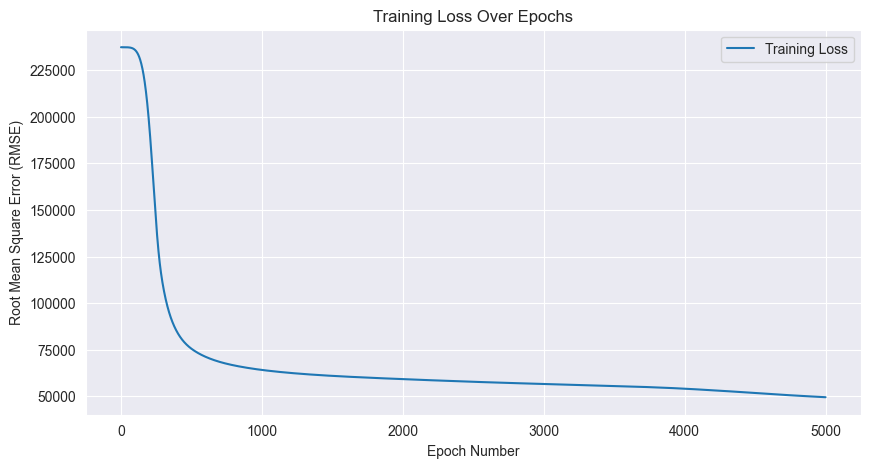

Evaluation RMSE: 53244.41015625


In [40]:
# Import necessary libraries for data scaling
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Scale the dataset
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)

# Convert scaled data into PyTorch tensors
train_data_tensor = torch.tensor(train_scaled, dtype=torch.float32)
train_labels_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)

test_data_tensor = torch.tensor(test_scaled, dtype=torch.float32)
test_labels_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

# Definition of the Multi-Layer Perceptron (MLP) model
class CustomMLP(nn.Module):
    def __init__(self, input_dim, output_dim, layers, neurons, activation_func):
        super(CustomMLP, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(input_dim, neurons)])
        self.layers.extend([nn.Linear(neurons, neurons) for _ in range(layers)])
        self.layers.append(nn.Linear(neurons, output_dim))
        self.activation = activation_func

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

# Function to train the model
def train_network(model, data, labels, num_epochs, learning_rate):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = nn.MSELoss()
    history = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(data)
        loss = torch.sqrt(loss_function(predictions, labels))
        loss.backward()
        optimizer.step()

        history.append(loss.item())
        if epoch % 100 == 0:
            print(f'Epoch: {epoch}, Loss: {loss.item()}')

    # Visualization of training loss
    plt.figure(figsize=(10, 5))
    plt.plot(history, label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch Number')
    plt.ylabel('Root Mean Square Error (RMSE)')
    plt.legend()
    plt.show()

# Function to evaluate the model performance
def evaluate_network(model, data, labels):
    model.eval()
    with torch.no_grad():
        predictions = model(data)
        loss = torch.sqrt(nn.MSELoss()(predictions, labels))
        print(f'Evaluation RMSE: {loss.item()}')

# Setting up the model's parameters and training it
input_features = train_data_tensor.shape[1]
model = CustomMLP(input_features, 1, 2, 100, F.relu)

# Training and evaluating the model
train_network(model, train_data_tensor, train_labels_tensor, 3000, 0.001)
evaluate_network(model, test_data_tensor, test_labels_tensor)


### Train the model

Using another model

In [38]:
# Define the considered model
class HousingNet(nn.Module):
    def __init__(self, input_dimension, output_dimension, n_hidden_layers, hidden_size, dropout_rate=0.2):
        super(HousingNet, self).__init__()

        self.input_dimension = input_dimension
        self.output_dimension = output_dimension
        self.n_hidden_layers = n_hidden_layers
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate

        layers = []
        # Define input layer
        layers.append(nn.Linear(input_dimension, hidden_size))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))

        # Define hidden layers
        for _ in range(n_hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))

        # Reduce to output dimension in the last layer without dropout
        layers.append(nn.Linear(hidden_size, output_dimension))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

- **input_dimension**: This parameter sets the number of input features that the model expects. Changing this value should correspond to the actual shape of your input data. Incorrect values here can lead to mismatch errors when you try to train your model.

- **output_dimension**: This defines the size of the model's output layer. In regression tasks (like predicting house values), this is often set to 1, representing a single continuous value. For classification, it might match the number of classes. Adjusting this parameter should align with your specific prediction goals.

- **n_hidden_layers**: The number of hidden layers in a neural network controls the depth of the model. More layers can increase the model's capacity to learn complex patterns but also risk overfitting and require more data and computational power to train effectively.

- **hidden_size**: This specifies the number of neurons in each hidden layer. Larger hidden layers can capture more information but also make the model more complex and prone to overfitting. Smaller layers might not capture complex patterns as effectively. In general, adding more layers tends to increase the capacity of the network to learn complex functions, while increasing the number of neurons in a layer can increase the network's ability to learn fine-grained details within a particular level of abstraction.

- **dropout_rate**: Dropout is a regularization technique to prevent overfitting by randomly setting a fraction of the input units to 0 at each update during training. A higher dropout rate increases the regularization effect but setting it too high can hinder the model's learning ability.

- **Learning Rate (lr)**: The learning rate controls how much the model's weights are updated during training. A high learning rate can cause the model to converge quickly but may overshoot the minimum loss. A low learning rate ensures more stable convergence but at the risk of getting stuck in local minima or taking too long to train.


In [39]:
def train_model(X_train_tensor, y_train_tensor, input_dimension, output_dimension, n_hidden_layers, hidden_size, dropout_rate, epochs=1000):
    model = HousingNet(input_dimension, output_dimension, n_hidden_layers, hidden_size, dropout_rate)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    loss_values = []  # List to store loss values

    for epoch in range(epochs):
        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save the loss value for plotting
        loss_values.append(loss.item())

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # Plotting the loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(loss_values, label='Training Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return model

In [ ]:
# Define multiple parameters to understand the best one to train our model
# variation of
input_dimension = X_train.shape[1]
output_dimension = 1  # Predicting a single value
n_hidden_layers = 3  # For example, 2 hidden layers
hidden_size = 64  # Example: each hidden layer has 32 neurons
dropout_rate = 0.2  # Example: 20% dropout rate


### Compare the model with what's present on the website

In the case, it's possible to compare the model with other examples

In [41]:
kf = KFold(n_splits=10, random_state=17, shuffle=True)
model=Ridge(alpha=1)
cv_scores = cross_val_score(model, X_train_tensor, y_train_tensor, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
print(np.sqrt(-cv_scores.mean()))

65881.1227092463


In [42]:
model = Lasso(alpha=0.1)
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
print(np.sqrt(-cv_scores.mean()))


/Users/guidoputignano/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.862e+13, tolerance: 2.486e+10
  model = cd_fast.enet_coordinate_descent(
/Users/guidoputignano/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.670e+13, tolerance: 2.466e+10
  model = cd_fast.enet_coordinate_descent(
/Users/guidoputignano/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

66047.521686664


/Users/guidoputignano/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.783e+13, tolerance: 2.464e+10
  model = cd_fast.enet_coordinate_descent(
/Users/guidoputignano/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.774e+13, tolerance: 2.476e+10
  model = cd_fast.enet_coordinate_descent(


In [43]:

model = RandomForestRegressor(n_estimators=100, random_state=17)
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
print(np.sqrt(-cv_scores.mean()))


48366.51777852388


In [44]:

model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
print(np.sqrt(-cv_scores.mean()))


118467.4562661413


In [45]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=17)
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
print(np.sqrt(-cv_scores.mean()))


70118.7716797383


The text then suggests other approaches such as

- **Use scaled features**: Standardize or normalize the features to have a mean of 0 and a standard deviation of 1, or to scale them within a range. This helps with the convergence of the model and can lead to better performance.

- **Add log features**: Transform certain features using the logarithm to reduce skewness and make their distribution more normal, which can improve model performance.

- **Add NaN and age clip indicating features**: Create indicator variables for missing values in your dataset and clip the age feature (or others) to a maximum value if outliers are present. This can help the model handle outliers and missing data more effectively.

- **Add city-distance features**: If relevant, calculate and include features that represent distances to key cities or locations. These geographical features can provide valuable information for prediction.

- **Generate several new features**: Explore the creation of new features through interactions between existing features, polynomial features, or other domain-specific feature engineering techniques.

- **Try to predict log(target) instead of target**: For regression tasks, predicting the logarithm of the target variable can help deal with skewness in the target distribution and can lead to performance improvements.

- **Tune some hyperparameters of the model**: Experiment with different settings for the model's hyperparameters to find the most effective configuration. Consider using techniques like grid search or random search to systematically explore the hyperparameter space.

### Describe the status quo in the literature

The data has been initailly featured in the paper: "Pace, R. Kelley, and Ronald Barry. "Sparse spatial autoregressions." Statistics & Probability Letters 33.3 (1997): 291-297."

In this case, they developed the following model:

In [101]:
# Simulate full_df for demonstration
np.random.seed(0)  # For reproducible output

# Preparing the data according to the model specification
X_reg = pd.DataFrame({
    'intercept': 1,  # For statsmodels, we manually add an intercept
    'median_income': full_df['median_income'],
    'median_income_squared': full_df['median_income']**2,
    'median_income_cubed': full_df['median_income']**3,
    'ln_median_age': np.log(full_df['housing_median_age']),
    'ln_total_rooms_over_population': np.log(full_df['total_rooms'] / full_df['population']),
    'ln_bedrooms_over_population': np.log(full_df['total_bedrooms'] / full_df['population']),
    'ln_population_over_households': np.log(full_df['population'] / full_df['households']),
    'ln_households': np.log(full_df['households']),
})

# Replace inf/-inf in X_reg with NaN
X_reg = X_reg.replace([np.inf, -np.inf], np.nan)

X_reg.fillna(X_reg.median(), inplace=True)

X_scaled = scaler.fit_transform(X_reg)

y_reg = np.log(full_df['median_house_value'])  # Target variable as ln(median house value)


model = sm.OLS(y_reg, X_reg).fit()


print(model.summary())

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     3973.
Date:                Fri, 29 Mar 2024   Prob (F-statistic):               0.00
Time:                        17:43:01   Log-Likelihood:                -8030.9
No. Observations:               20640   AIC:                         1.608e+04
Df Residuals:                   20631   BIC:                         1.615e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
intercept   

To predict the natural logarithm of the median house value based on various features, we first transform our target variable using the natural logarithm to improve the normality of its distribution. After preparing our predictors in the DataFrame `X_reg`, we fit an Ordinary Least Squares (OLS) regression model using `statsmodels`.
The model isn't super robust, describing the importance of current ML methods that substituted this approach